## Backpropagate uncertainties from dN/dNmu fit to cross section and surface flux

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np
from scipy.optimize import curve_fit
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm
from MCEq.data import InteractionCrossSections

import crflux.models as pm

import  mceq_underground_helper_forsplines as helper

from slope_param_functions import sl_depth
import seaborn as sns

In [2]:
# for plotting

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

colors = sns.color_palette("colorblind")

plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [3]:
def propagate_uncertainty(jacobian, cov_matrix):
    return np.sqrt(jacobian.T @ cov_matrix @ jacobian)

In [17]:
mceq_air = MCEqRun(
    interaction_model="SIBYLL23C",
    theta_deg=0.0,
    primary_model=(pm.GlobalSplineFitBeta, None),
    density_model = ('MSIS00_IC',('South Pole','January')),
)

mceq_air.set_interaction_model("SIBYLL23C", force=True)
mceq_air.set_theta_deg(0)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('South Pole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): GlobalSplineFitBeta 
MCEqRun::set_interaction_model(): SIBYLL23C
MCEqRun::set_primary_model(): GlobalSplineFitBeta 


In [7]:
# read errors from fit, use test for now

cov_abc_opt = np.array([
    [0.01, 0.003, -0.002],
    [0.003, 0.02, 0.001],
    [-0.002, 0.001, 0.005]
])

#with open("/hetghome/khymon/cs-files/dNdNmu_fit-pi-air.pkl", "rb") as f:
#    popt, pcov = pickle.load(f)

In [8]:
# read derivatives from surface flux and cross section pion-air

with open("/hetghome/khymon/cs-files/deriv_surfaceflux.pkl", "rb") as f:
    dphi_a, dphi_b, dphi_c = pickle.load(f)


with open("/hetghome/khymon/cs-files/deriv_sigma_pi-air.pkl", "rb") as f:
    dsig_da, dsig_db, dsig_dc = pickle.load(f)

In [9]:
# choose index for

jac_phi = np.array([
    dphi_a[0],
    dphi_b[0],
    dphi_c[0]
])
delta_phi = propagate_uncertainty(jac_phi, cov_abc_opt)

/tmp/ipykernel_1656380/1073886119.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(jacobian.T @ cov_matrix @ jacobian)


In [20]:
jac_sig = np.array([
    dsig_da,
    dsig_db,
    dsig_dc])
delta_sig= propagate_uncertainty(jac_sig, cov_abc_opt)
sig_err = np.sqrt(np.diag(delta_sig))

/tmp/ipykernel_1656380/1073886119.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(jacobian.T @ cov_matrix @ jacobian)


<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1656380/1360363759.py:25: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$E_{\pi}$ [GeV]')
/tmp/ipykernel_1656380/1360363759.py:26: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma_{\pi - \mathrm{air}}$ [mb]')


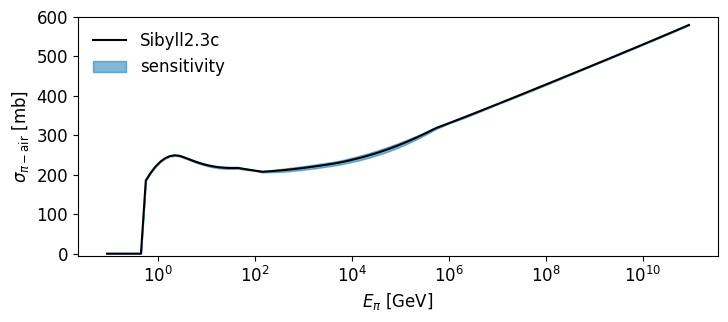

In [23]:
# create final plots with error bands - sibyll =def cross section

sig_def = InteractionCrossSections(mceq_air._mceq_db,interaction_model='SIBYLL23C').get_cs(211, mbarn=True)

fig_width = 2*4.13 
fig_height = 3.1  # adjust for aspect ratio

plt.rcParams.update({
    "font.size": 12,         # 12 pt font
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

colors = sns.color_palette("colorblind")

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

ax.plot(mceq_air.e_grid,sig_def,label='Sibyll2.3c',color='black')
ax.fill_between(mceq_air.e_grid,sig_def - sig_err,sig_def + sig_err,label = 'sensitivity',alpha=0.5, color=colors[0])



ax.legend(frameon=False,loc='upper left')
ax.set_xlabel('$E_{\pi}$ [GeV]')
ax.set_ylabel('$\sigma_{\pi - \mathrm{air}}$ [mb]')
ax.set_ylim(-5,600)


plt.xscale('log')



<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1656380/253456088.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma_{\pi - \mathrm{air}}$ [mb]')
/tmp/ipykernel_1656380/253456088.py:29: SyntaxWarning: invalid escape sequence '\p'
  ax_ratio.set_xlabel('$E_{\pi}$ [GeV]')
/tmp/ipykernel_1656380/253456088.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = sig_def / sig_def
/tmp/ipykernel_1656380/253456088.py:22: RuntimeWarning: invalid value encountered in divide
  ratio_err = sig_err / sig_def


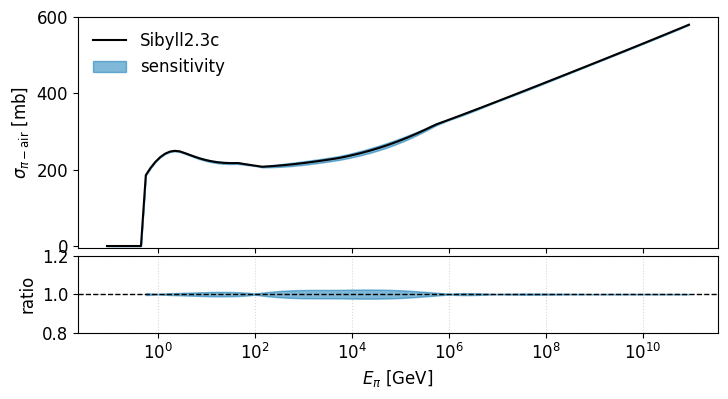

In [ ]:
fig, (ax, ax_ratio) = plt.subplots(
    nrows=2,
    sharex=True,
    figsize=(fig_width, 4.1),
    gridspec_kw={"height_ratios": [3, 1]}
)

# --- Top plot: cross section ---
ax.plot(mceq_air.e_grid, sig_def, label='Sibyll2.3c', color='black')
ax.fill_between(mceq_air.e_grid, sig_def - sig_err, sig_def + sig_err,
                label='sensitivity', alpha=0.5, color=colors[0])

ax.legend(frameon=False, loc='upper left')
ax.set_ylabel('$\sigma_{\pi - \mathrm{air}}$ [mb]')
ax.set_ylim(-10, 600)
ax.set_xscale('log')
ax.tick_params(labelbottom=False)

# --- Bottom plot: ratio ---
# Here we compare the band to itself — result should be ~1 ± uncertainty
ratio = sig_def / sig_def
ratio_err = sig_err / sig_def

ax_ratio.fill_between(mceq_air.e_grid, 1 - ratio_err, 1 + ratio_err,
                      color=colors[0], alpha=0.5)

ax_ratio.axhline(1, color='black', linestyle='--', linewidth=1)
ax_ratio.set_ylabel('ratio')
ax_ratio.set_xlabel('$E_{\pi}$ [GeV]')
ax_ratio.set_xscale('log')
ax_ratio.set_ylim(0.8, 1.2)
ax_ratio.grid(True, linestyle=':', alpha=0.5)

# Adjust spacing
plt.subplots_adjust(hspace=0.05)

plt.savefig(plot_dir + 'pi-air_sensitivity.pdf')